# Hypothesis and Outline

### Introduction

Would you base your decision of which wine to buy on the opinion of human experts or on the chemical properties that make up the wine itself? In reality, both play a role in how wine quality is certified. Traditionally, wine quality is determined through sensory analysis conducted by trained experts, a subjective process that can be time-consuming and difficult to scale. On the other hand, physicochemical lab tests measure objective traits, which are faster and more cost-effective, but do not directly assign a quality rating. This project examines whether machine learning can connect these objective chemical properties to subjective quality scores, focusing on wines from the Vinho Verde region. By doing so, the study explores the potential for automating parts of the certification process, identifying which chemical factors most influence perceived quality, and reducing reliance on costly human tasting panels.


### Hypotheses

(1) We hypothesize that alcohol content is the main positive driver of quality. We expect a statistically significant positive coefficient for alcohol in our models. (2) We hypothesize that the relationship between physicochemical attributes and human taste is inherently nonlinear. Therefore we claim that nonlinear methods like Random Forests or XGBoost will yield significantly better results when examining log loss and F1 Score in comparison to logistic regression with regularization (LASSO and Ridge). These hypotheses form testable claims that align with our objectives of variable importance and model performance differences.

### Outline

1. We started with Exploratory Data Analysis (EDA). We looked at things such as descriptive statistics (mean, median, maximum, etc.), the distributions of each variable, and a correlation matrix.
2. We will then run a multinomial logistic regression model as a baseline predictor model (we will look at one without regularization and with regularization).
3. Then we will run a XGBoost model.
4. Finally, we will compare the 2 models and analyze the results.

### How do these results evaluate our hypotheses?

To evaluate the alcohol-quality hypothesis, we will examine the sign and significance of the alcohol coefficient in linear & regularized models & review alcohol’s feature importance ranking in nonlinear models.

If nonlinear models yield significantly better results (Brier score, F1 score, lower cross entropy), this will support our hypothesis that nonlinear relationships improve wine quality prediction.


# Describing the Data
### Variable Description

The 12 predictor variables (X) are the 11 physicochemical attributes, as well as wine type, & the target variable (Y) is the expert-assigned wine quality rating.

Fixed acidity:

*   Represents the non-volatile acids in the wine (acids that don’t evaporate easily), primarily referring to tartaric acid
* Measured in g/dm³ (grams per cubic decimeter), higher values are a more acidic, tart wine, which is desirable for structure and stability



Volatile acidity

*   The amount of acetic acid in the wine, which is a byproduct of fermentation or spoilage bacteria
* Measured in g/dm³, low levels are preferred as high levels are undesirable and lead to unpleasant vinegar taste and smell



Citric acid

*   A weak organic acid found in small quantities, sometimes added to boost acidity
* Measured in g/dm³, contributes “freshness” and fruit flavors to the wine



Residual sugar

*   The amount of sugar remaining in the wine after fermentation stops
* Measured in g/dm³, values typically range from 0 to 45+



Chlorides

*   The amount of salt in the wine
* Measured in g/dm³(sodium chloride), high levels can lead to salty taste, which is generally undesirable



Free Sulfur Dioxide

*   The free form of sulfur dioxide which is the active part that prevents microbial growth and oxidation
* Measured in mg/dm³, acts as an antimicrobial and antioxidant



Total Sulfur Dioxide

*   The sum of free sulfur dioxide and sulfur dioxide bound to other molecules
* Measured in mg/dm³, it’s undetectable at low concentrations but evident in the nose and taste at concentrations above 500 parts per million



Density

*   The density of the wine relative to water
* Measured in g/dm³, depends on the percent alcohol and sugar content (both different densities than water)



pH

*   A measure of how acidic or basic the wine is
* A scale from 0 (very acidic) to 14 (very basic), most wines are between 3 and 4


Sulphates

*   A wine additive (potassium sulphate) which can contribute to sulfur dioxide gas levels
* Measured in g/dm³, acts as an antimicrobial and antioxidant to preserve wine quality over time



Alcohol

*   Percent alcohol content of the wine
* Measured in % by volume, a key driver of wine’s body and perceived quality



Wine Type

*   The color of wine being tested (red or white)



Quality

*   The rating of wine quality from 0 (very bad) to 10 (excellent) from wine quality experts





### Sources, Collection Methods, and Pre-Processing Steps

Data Souce
* Our project’s data source is the Wine Quality dataset from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/186/wine+quality).

Collection Methods

* This was collected from a 2009 study by Paulo Cortez
The physicochemical data was collected using laboratory analysis for the wine
* The quality scores were observed by wine experts doing blind taste tests

Preprocessing Steps
* Original researchers took the median of the wine quality score (multiple experts rated the same wine)
* The original researchers removed any samples with obvious measurement errors
* We combined the red and white wine datasets into one dataset
* We added one predictor column specifying if the data point corresponded to a red wine or a white wine


### Sources

Paulo Cortez, António Cerdeira, Fernando Almeida, Telmo Matos, José Reis,
Modeling wine preferences by data mining from physicochemical properties,
Decision Support Systems,
Volume 47, Issue 4,
2009,
Pages 547-553,
ISSN 0167-9236,
https://doi.org/10.1016/j.dss.2009.05.016.
(https://www.sciencedirect.com/science/article/pii/S0167923609001377)


### Contextual Information

This data was collected in 2009, so it is slightly outdated. Additionally, this data only looks at the Vinho Verde region, so we only looked at one specific region. All variables are continuos expecpt for quality, which is categorical, and wine type, which is binary.

# Imports

In [ ]:
# Run next line only if optuna is not installed already
!pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import xgboost as xgb  # xgb.XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Read Data In

In [ ]:
# We download directly from UCI in order to avoid any data download errors.
red = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
white = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

# We are evaluating the combined wine types. We want to have a predictor that states what type of wine it is.
# Thus, we are adding it ourselves.
red['wine_type'] = 'red'
white['wine_type'] = 'white'


# Combine
wine_data = pd.concat([red, white], axis=0, ignore_index=True)

wine_data['wine_type'] = (wine_data['wine_type'] == 'red').astype(int)

# EDA

In [ ]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


<Axes: >

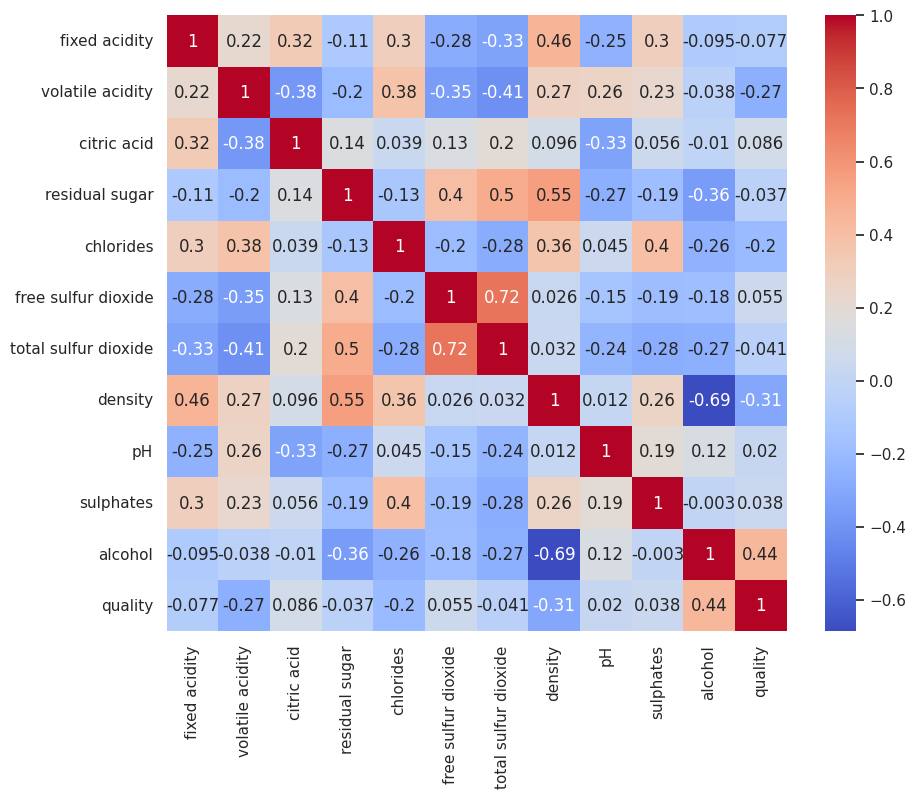

In [ ]:
wine_data_subset = wine_data.drop(columns = 'wine_type', axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(wine_data_subset.corr(), annot=True, cmap='coolwarm')

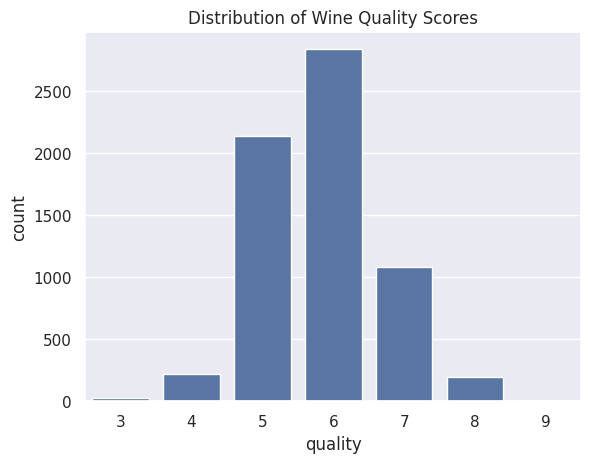

In [ ]:
sns.set()
sns.set_theme()
sns.countplot(x='quality', data=wine_data)
plt.title('Distribution of Wine Quality Scores')
plt.show()

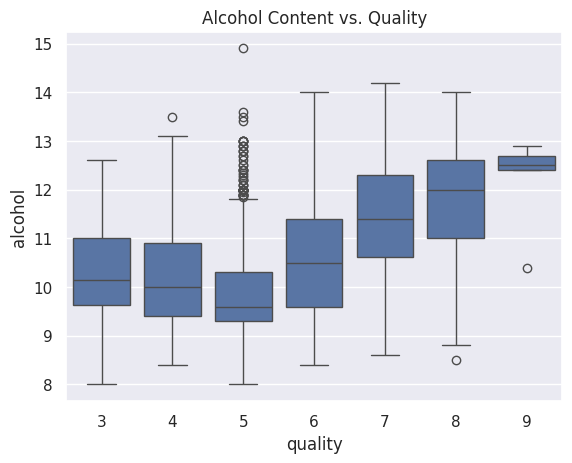

In [ ]:
sns.boxplot(x='quality', y='alcohol', data=wine_data)
plt.title('Alcohol Content vs. Quality')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

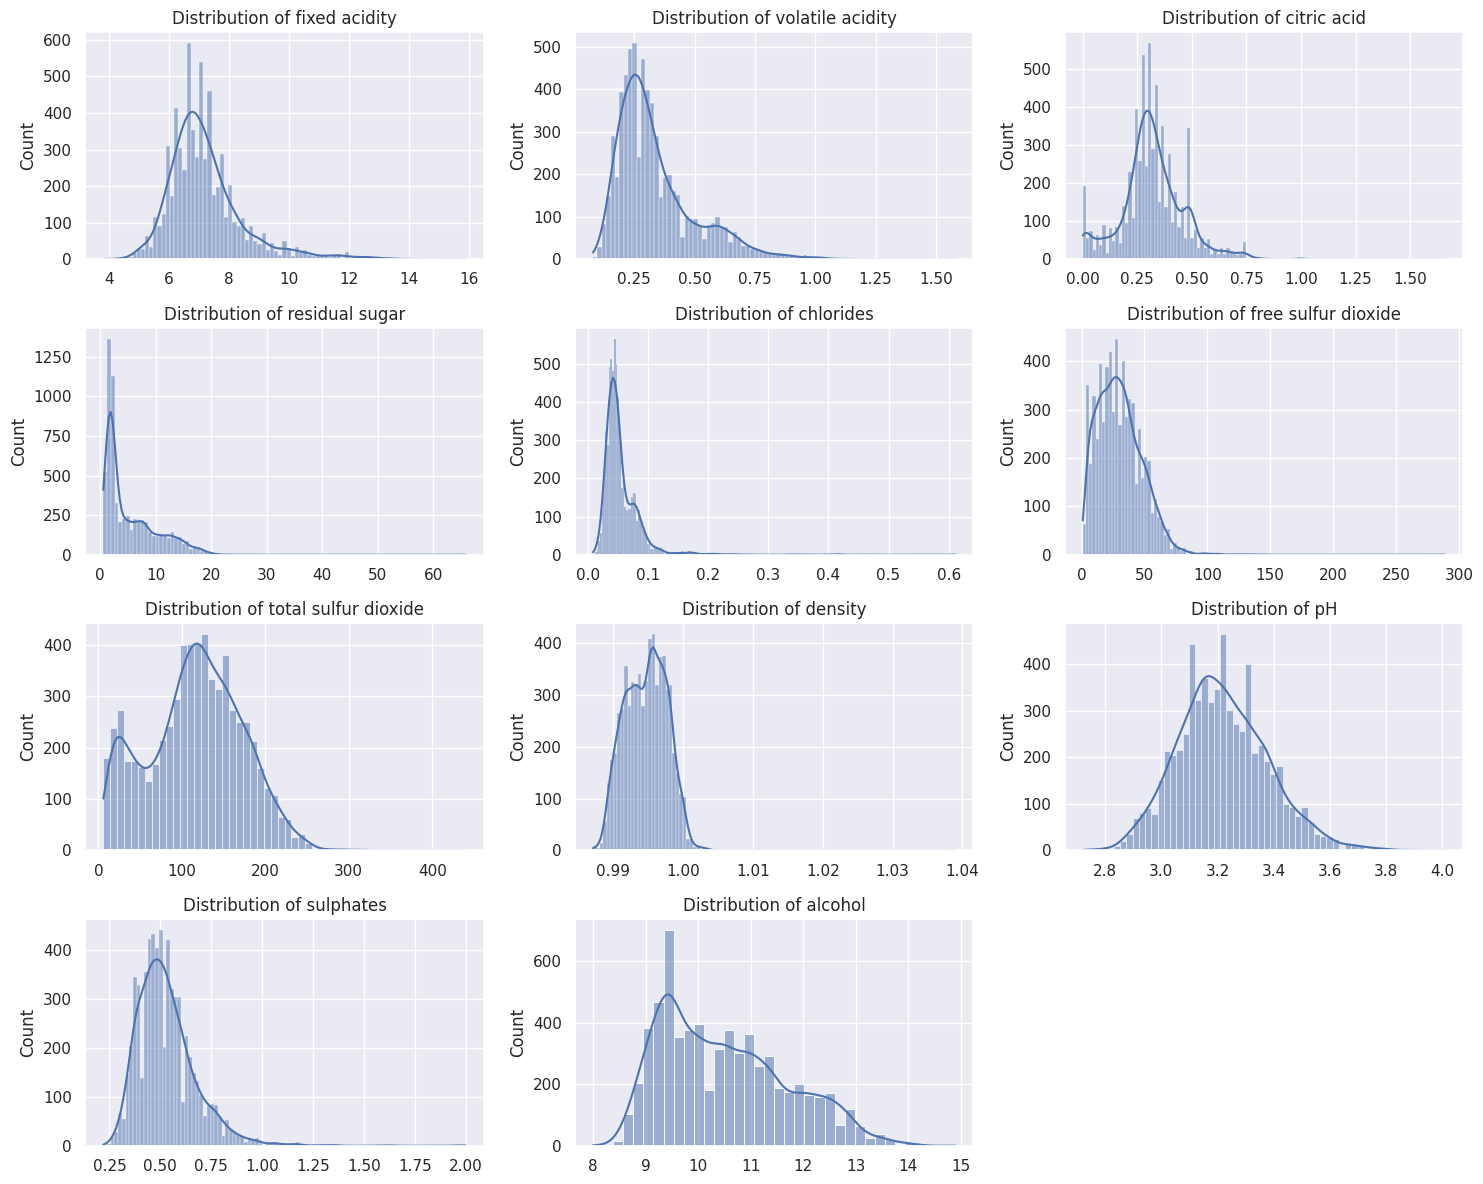

In [ ]:
# Select only continuous variables by dropping quality
continuous_vars = wine_data_subset.columns.drop('quality')

# Create grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,12))
axes = axes.flatten()

# Loop through columns and plot each one
for i, col in enumerate(continuous_vars):
    sns.histplot(wine_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# Delete unused sub plots
for j in range(len(continuous_vars), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
plt.tight_layout()
plt.show

In [ ]:
# Split into train and test split
X = wine_data.drop("quality", axis = 1)
y = wine_data["quality"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42, stratify = y)

# Scale features:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Feature names for later:
feature_names = X_train.columns

# This will be used for validation and hyperparameter tuning later
cv_splitter = StratifiedKFold(
    n_splits = 3,
    shuffle = True,
    random_state = 42
)

# Model Training


## Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000, multi_class="multinomial", penalty=None)

model.fit(X_train_scaled, y_train_encoded)

y_pred = model.predict(X_test_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
classification = classification_report(y_test_encoded, y_pred)
print(classification)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       1.00      0.04      0.07        54
           2       0.57      0.54      0.56       535
           3       0.51      0.71      0.60       709
           4       0.58      0.28      0.38       270
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00         1

    accuracy                           0.54      1625
   macro avg       0.38      0.22      0.23      1625
weighted avg       0.54      0.54      0.51      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_prob = model.predict_proba(X_test_scaled)
from sklearn.metrics import log_loss

test_log_loss = log_loss(y_test_encoded, y_prob)
print("Test Log Loss:", test_log_loss)

# Predicted probabilities on TRAINING data
y_prob_train = model.predict_proba(X_train_scaled)

# Training log loss
train_log_loss = log_loss(y_train_encoded, y_prob_train)

print("Training Log Loss:", train_log_loss)

Test Log Loss: 1.0832674714204464
Training Log Loss: 1.054018116931027


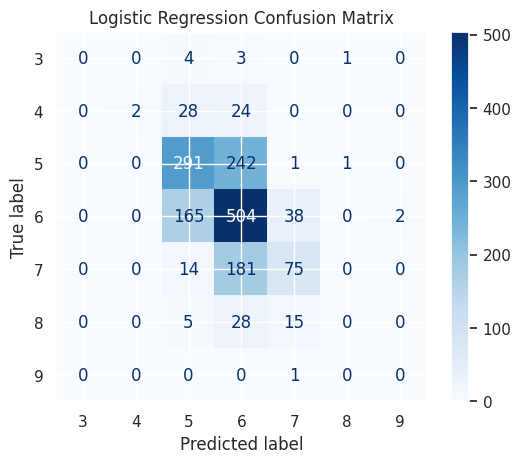

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded,
    y_pred,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [ ]:
coef_df = pd.DataFrame(
    model.coef_,
    columns=feature_names,
    index=label_encoder.classes_
)

coef_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False)
coef_importance.head(13)

,0
chlorides,2.188344
fixed acidity,1.625453
density,1.420982
residual sugar,1.143757
pH,1.126942
wine_type,0.988136
volatile acidity,0.708521
alcohol,0.510946
free sulfur dioxide,0.310979
sulphates,0.257460


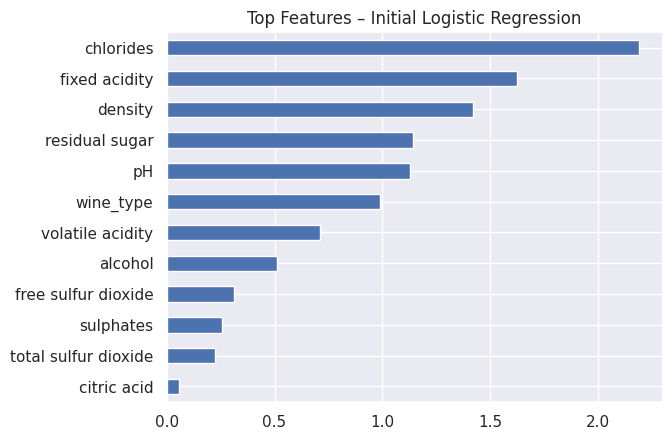

In [ ]:
coef_importance.head(13).sort_values().plot(kind="barh")
plt.title("Top Features – Initial Logistic Regression")
plt.show()

In [ ]:
######################START OF HYPERPARAMETER TUNING###########################################

Cs = np.logspace(-3, 2, 6)
cv_scores = []

for C in Cs:
    lr = LogisticRegression(
        C=C,
        max_iter=1000,
        multi_class="multinomial"
    )
    scores = cross_val_score(
        lr,
        X_train_scaled,
        y_train_encoded,
        cv=cv_splitter,
        scoring="neg_log_loss"
    )
    cv_scores.append((C, -scores.mean()))

cv_scores


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

[(np.float64(0.001), np.float64(1.167002252727871)),
 (np.float64(0.01), np.float64(1.1004368549355499)),
 (np.float64(0.1), np.float64(1.079681978534055)),
 (np.float64(1.0), np.float64(1.078424866562479)),
 (np.float64(10.0), np.float64(1.0798095901605789)),
 (np.float64(100.0), np.float64(1.0803481194015265))]

In [ ]:
best_C = min(cv_scores, key=lambda x: x[1])[0]

model = LogisticRegression(
    C=best_C,
    max_iter=1000,
    multi_class="multinomial"
)
model.fit(X_train_scaled, y_train_encoded)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=np.float64(1.0), max_iter=1000, multi_class='multinomial')

In [ ]:
final_model = LogisticRegression(
    C=best_C,
    max_iter=1000,
    multi_class="multinomial",
)

final_model.fit(X_train_scaled, y_train_encoded)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=np.float64(1.0), max_iter=1000, multi_class='multinomial')

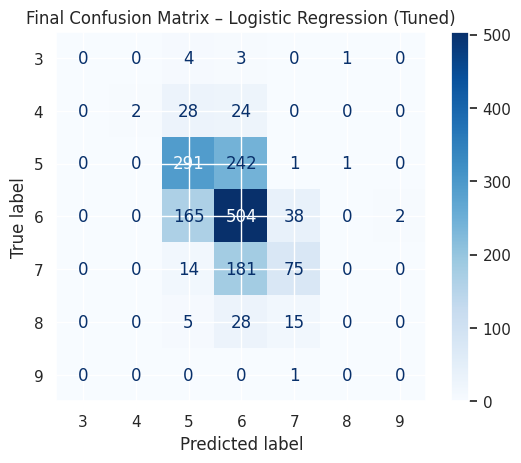

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded,
    y_pred,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)
plt.title("Final Confusion Matrix – Logistic Regression (Tuned)")
plt.show()


In [ ]:
coef_df = pd.DataFrame(
    final_model.coef_,
    columns=feature_names,
    index=label_encoder.classes_
)

coef_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False)
coef_importance.head(13)


,0
wine_type,0.646590
alcohol,0.574907
density,0.563209
volatile acidity,0.553248
residual sugar,0.504294
fixed acidity,0.485501
pH,0.370004
free sulfur dioxide,0.333012
chlorides,0.324498
sulphates,0.279256


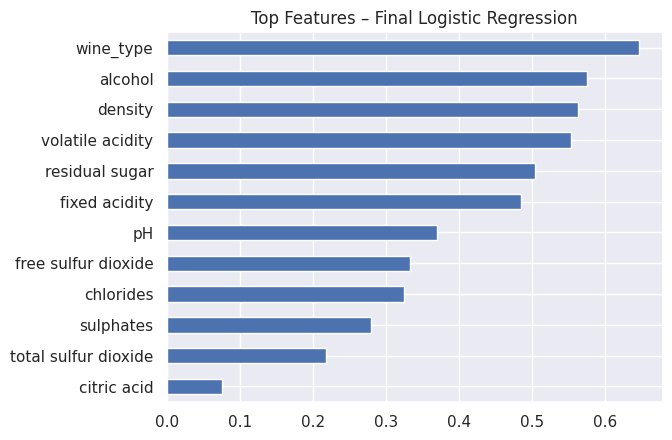

In [ ]:
coef_importance.head(13).sort_values().plot(kind="barh")
plt.title("Top Features – Final Logistic Regression")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, log_loss

# Predictions
y_pred_final = final_model.predict(X_test_scaled)
y_prob_final = final_model.predict_proba(X_test_scaled)

# Classification report
print("Final Logistic Regression – Classification Report")
print(classification_report(
    y_test_encoded,
    y_pred_final,
    target_names=label_encoder.classes_.astype(str)
))

# Log loss
final_test_log_loss = log_loss(y_test_encoded, y_prob_final)
print("Final Logistic Regression – Test Log Loss:", final_test_log_loss)

final_train_log_loss = log_loss(y_train_encoded, final_model.predict_proba(X_train_scaled))
print("Final Logistic Regression – Training Log Loss:", final_train_log_loss)


Final Logistic Regression – Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       1.00      0.04      0.07        54
           5       0.57      0.54      0.56       535
           6       0.51      0.71      0.60       709
           7       0.57      0.28      0.37       270
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1625
   macro avg       0.38      0.22      0.23      1625
weighted avg       0.54      0.54      0.51      1625

Final Logistic Regression – Test Log Loss: 1.0710126051952216
Final Logistic Regression – Training Log Loss: 1.0559336686100274


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost

In [ ]:
# XGBoost Model with Optuna optimizing hyperparameters
# Note that I was introduced to Optuna for a job which is where I have experience with it as well as using for a different class.

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss

optuna.logging.set_verbosity(optuna.logging.WARNING)
#Objective function for XGBoost

def objective_xgb(trial):
  # Range of hyperparameter choices
  params = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
    }

  use_class_weight = trial.suggest_categorical('use_class_weight', [True, False])

  model = xgb.XGBClassifier(**params, random_state = 42, n_jobs = -1, eval_metric = 'mlogloss', early_stopping_rounds = 20)

  # Sample weights for the iterations when needed (use_class_weight = True)
  if use_class_weight:
    sample_weights = compute_sample_weight('balanced', y_train_encoded)
  else:
    sample_weights = None

  scores = []
  for train_idx, val_idx in cv_splitter.split(X_train_scaled, y_train_encoded):
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    # Get weights
    fold_weights = sample_weights[train_idx] if use_class_weight else None

    model.fit(X_fold_train, y_fold_train, sample_weight = fold_weights, eval_set = [(X_fold_val, y_fold_val)], verbose = False)
    y_pred_proba = model.predict_proba(X_fold_val)
    score = -log_loss(y_fold_val, y_pred_proba, labels = np.arange(len(np.unique(y_train_encoded))))
    scores.append(score)

  return(np.mean(scores))


# Optimize
study_xgb = optuna.create_study(direction = 'maximize')
study_xgb.optimize(objective_xgb, n_trials = 100, show_progress_bar = True)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Train model with optimal hyperparameters

# Best hyperparameter values
for name, value in study_xgb.best_params.items():
  print(f" {name}; {value}")

best_params_xgb = {k: v for k,
                   v in study_xgb.best_params.items() if k != 'use_class_weight'}
use_best_class_weight = study_xgb.best_params['use_class_weight']

best_model = xgb.XGBClassifier(**best_params_xgb, random_state = 42, n_jobs = -1, eval_metric = 'mlogloss')

#Fit

if use_best_class_weight:
  sample_weights_train = compute_sample_weight('balanced', y_train_encoded)
  best_model.fit(X_train_scaled, y_train_encoded, sample_weight = sample_weights_train)
else: best_model.fit(X_train_scaled, y_train_encoded)

# Predictions
y_train_pred = best_model.predict(X_train_scaled)
y_train_pred_proba = best_model.predict_proba(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)

# Decode for clairty when looking at plot
y_train_pred_xgb = label_encoder.inverse_transform(y_train_pred)
y_test_pred_xgb = label_encoder.inverse_transform(y_test_pred)

# Train vs Test log loss
train_log_loss = log_loss(y_train_encoded, y_train_pred_proba)
test_log_loss = log_loss(y_test_encoded, y_test_pred_proba)

print(train_log_loss)
print(test_log_loss)

 max_depth; 7
 learning_rate; 0.0698790906583681
 n_estimators; 273
 min_child_weight; 1
 subsample; 0.8245582078201217
 colsample_bytree; 0.814670425049358
 reg_alpha; 0.003725811620474695
 reg_lambda; 1.833203262560538
 use_class_weight; False
0.18635206400275098
0.8531619757737771


In [ ]:
print(classification_report(y_test, y_test_pred_xgb))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.56      0.19      0.28        54
           5       0.72      0.70      0.71       535
           6       0.66      0.77      0.71       709
           7       0.66      0.61      0.63       270
           8       0.95      0.38      0.54        48
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1625
   macro avg       0.51      0.38      0.41      1625
weighted avg       0.68      0.68      0.67      1625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 feature  importance
2            citric acid    0.062971
4              chlorides    0.062982
0          fixed acidity    0.063436
8                     pH    0.064538
6   total sulfur dioxide    0.068958
9              sulphates    0.069718
5    free sulfur dioxide    0.071346
3         residual sugar    0.072121
7                density    0.077573
1       volatile acidity    0.085871
10               alcohol    0.143406
11             wine_type    0.157080


Text(0.5, 1.0, 'XGBoost Feature Importance')

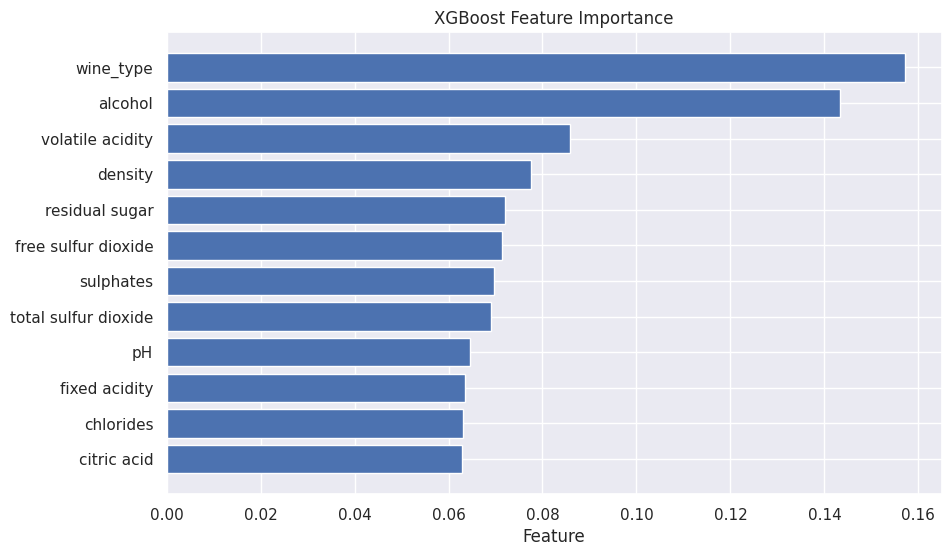

In [ ]:
# Feature Importance

xgboost_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending = True)

print(xgboost_imp)

plt.figure(figsize=(10,6))
plt.barh(xgboost_imp['feature'], xgboost_imp['importance'])
plt.xlabel('Feature')
plt.title('XGBoost Feature Importance')


**Logistic Ridge Regularization Model Summary:**

Our final logistic regression model with ridge regularization performed decent. The best ridge regularization had a "C" value of 1.0, which is a moderate regularization.

The overall accuracy of the model was 54% on the test set, which is moderate for a multi-class classification. This means our model corretly predicted the correct wine quality value 54% of the time. Our model's generalizabilty is reasonable because the training log loss is 1.0559 and the test log loss is 1.0710. This small increase from training to test suggests the model is not significantly overfitting to the training data and is generalizing fairly well.

We do note that while the feature importance is vastly different between the regualrized and unregularized model, the classification report was the same and log loss is very similar. This is likely due to multicolinearity. While we checked stronger lambda's for regularization, it did not perform as well. However, the regularization should lend us some help in being more confident in our interpretation which is why we went with that model.

**XGBoost Model Summary:**

The XGBoost model performed decently well. We do note that there is definetely some overfitting based on the relatively large gap between the training and testing log loss. Adjustments were tried to correct this with the hyperparameter tuning by setting a strictor cap on model complexity using max tree depth and min child weight. However, it hurt the accuracy significantly on both training and testing.

Thus, I kept it in the form you see now. It performs admirably with almosta  70% accuracy. It struggles on the classes that have few data points which is to be expected.

# Model Comparison and Evaluation

- Logistic Regression:
  - The original model without regularization had chlorides (2.19), fixed acidiity (1.63), and density (1.42) as the main predictors. The log loss was 1.083 on the test set.
  - We then created the model with ridge regression with a C value of 1. This model had Wine Type (0.65), alcohol percentage (0.57), and density (0.56). The log loss was 1.071 on the test set.
  - The differences as far as the classification report is concerned is neglible between these two. The accuracy was 0.54 and the weighted average F1 score was 0.51 for both.
  - We note the oddity of having the two nodels having vastly different top important features. While our correlation matrix did not show any overly concerning high correlations, we deduce this is likely due to multicolinearity. Thus, interpretability is difficult and our interpretation may or may not be fully correct. However, for the logistic regression model, we chose to go with the ridge model as these coefficients are more stable. However, we note that there is still the possibility of explantory power being split between correlated features.

- XGBoost:
  - The XGBoost model had its hyperparameters tuned using Optuna. Optuna is an import that allows for "smart" training of hyperparameters. It learns from previous iterations and focuses on the subset of hyperparameters that produced better results than other subsets. Some of the hyperparameters that were tuned include max_depth, min_child_weight, n_estimators, and more. After Optuna learned the best set of hyperparameters, we trained our final model with those.
  - The most important features from this model were wine_type (0.17), alcohol percentage (0.15), and volatile acidity (0.09).
  - Looking at the classification report, we have an accuracy of 68% with a weighted F1 score of 0.67. We also note that the log loss for the test was 0.848. We do experience a case of overfitting as the log loss for training was 0.177. However, this was the best we could get this model to do.
  - For interpretability, this model is also somewhat hard to interpret due to it's natural inclusion of interactions. However, we can be confident that our feature importances correctly show the main effect feature importances.

# Final Model Decision

The XGBoost model is clearly the better model choice for this problem. It vastly outperformed the logistic regression model on accuracy, weighted F1 score, and log loss. Thus, it was a much better model fit. Additionally, while not perfect, our feature importances are more trustworthy for the XGBoost model (at least in terms of main effects). Thus, we would choose the XGBoost model.

# Conclusions, Limitations, and Implications

### Hypotheses answered:
- Our first hypothesis was that alcohol content would be the number one positive driver in quality score. However, looking at the main effect feature importances from the XGBoost model, we see that wine type was the number one positive predictor of quality. Thus, this hypothesis was proven to be wrong.

- Our second hypothesis was that the relationship between physicochemical properties and human taste is inherently non linear. Thus, non linear methods such as XGBoost shoudl significantly outperform logistic regression models. Our resutls do indeed support this as XGBoost was significantly better. However, more research is needed to truly make an assertion on the validity of this.

### Limitations
- There are several limitations in our study.
  - The biggest one is the limited data on extremly high or low quality wines. This makes it inherently difficult to predict these cases.
  - Another limitation is not having interaction terms in our logistic regression model. This is why we are not yet able to make a confident assertion that the relationship is indeed non linear. It is within the realm of reason that logistic regression would perform similarly to XGBoost when interactions are included.
  - Finally, our interpretation metrics for logistic regression are limited due to likely multicolinearity.

### Future Research
- Future research should incldue SHAP methods in order to bridge the gap in interpretability. Additonally, they should incldue interaction terms in the logistic regressiion model.
- Also, it would be interesting to see the effect of other wine types on this analysis. Is wine type truly the most important predictor when including all wine types?
- Additionally, finding more possible features to study would be important. There are limited features to choose from. It is hard to even apply regularization due to the low amount of possible features. If we had more features (that truly had predictive power outside of what we have now), we might have better accuracy and the ability to apply more regularization.
- Lastly, we only have data from a certain region. Having more data from more regions would be interesting to study.

### Fianl Thoughts
- Our XGBoost model significantly outperformed our linear regression model. This provides evidence that this relationship might be non-linear. However, more research is needed to be done as mentioned above. This is a great jumping off point but a lot more work must be done before we can begin to truly make conclusions.